In [1]:
import os
import sys 

import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import tensorflow as tf
from skimage import io
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, recall_score, precision_score
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)

from data_generator_3d import *
from model import *
from plotting_helpers import plot_auc

print(tf.__version__)

1.14.0


In [2]:
image_generator = ImageDataGenerator(
#     rotation_range=5,
    rescale=1./255,
#     shear_range=.1, 
#     zoom_range=.05,
    brightness_range=[.85, 1.0],
#     zca_whitening=True,
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=5,
    width_shift_range=5,
    fill_mode='nearest',
    validation_split=0.0
)

label_generator = ImageDataGenerator(
    validation_split=0.0
)

train_generator = generator(
    base_directory='data/nlst_train/image_roi_3d',
    input_gen=image_generator,
    target_gen=label_generator,
    batch_sz=1
)

val_generator = generator(
    base_directory='data/nlst_val/image_roi_3d',
    input_gen=image_generator,
    target_gen=label_generator,
    batch_sz=1
)

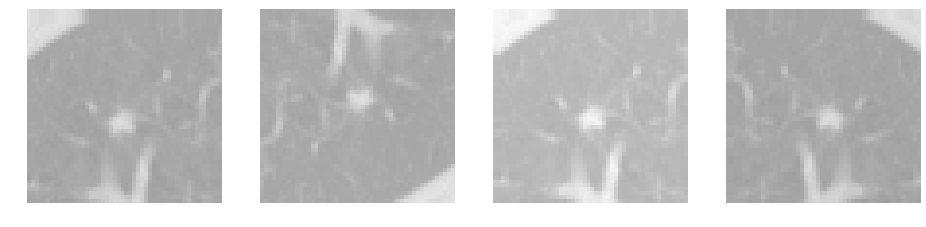

In [3]:
show_augmentation('data/nlst_train/image_roi_3d/25/0.tif', image_generator, n_rows=1)

In [4]:
model = CNN_3D(input_shape=(50, 50, 50, 1))

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
    loss=weighted_cross_entropy,
    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# model.summary()

In [ ]:
# model_history = model.fit_generator(
#     train_generator,
#     validation_data= val_generator,
#     validation_steps=200,
#     steps_per_epoch=1000,
#     epochs = 10
# )

In [ ]:
# model.save('nlst_cnn.hdf5') 

In [7]:
model.load_weights('nlst_cnn_curbest.hdf5')
# model.load_weights('nlst_cnn.hdf5')

In [8]:
Xs = []
Ys = []
for im in os.listdir('data/nlst_test/image_roi_3d/pkls/'):
    path = f'data/nlst_test/image_roi_3d/pkls/{im}'
    with open(path, 'rb') as input_file:
        cube, label = pkl.load(input_file)
    cube = cube[:50][:50][:50]
    if cube.shape[0] < 50 or cube.shape[1] < 50 or cube.shape[2] < 50:
        pass
    else:
        Xs.append(np.array(cube/255).reshape(50, 50, 50, 1))
        Ys.append(label)

0.7272727272727273
0.5992887890698109


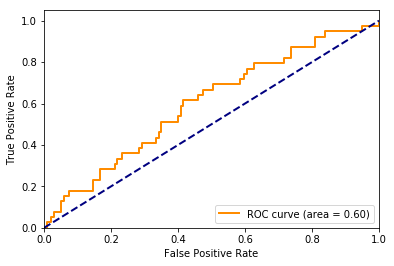

In [9]:
Xs = np.array(Xs)
Ys = np.array(Ys)
preds = np.concatenate([model.predict(Xs[i*5:min((i+1)*5, 177)]) for i in range(36)])
print(accuracy_score(Ys, np.round(preds)))
print(roc_auc_score(Ys, preds))

fig, ax = plt.subplots(1, 1)
plot_auc(Ys, preds, ax)

# Patient Model

In [10]:
df = pd.read_csv('data/nlst_patient_table.csv')
df.head()

,pid,recurrence,adjuvent,age,gender,stage 1a,stage 1b,stage 2a,stage 2b,stage 3a,stage 3b,stage 4
0,100012,1.0,0,61,2,1,0,0,0,0,0,0
1,100242,1.0,0,60,2,1,0,0,0,0,0,0
2,100280,0.0,0,60,2,1,0,0,0,0,0,0
3,100570,0.0,0,63,1,1,0,0,0,0,0,0
4,100658,0.0,0,60,1,0,1,0,0,0,0,0


In [11]:
mean_preds = []
highest_preds = []
for pid in df.pid:
    preds = []
    if not os.path.exists(f'data/nlst_rois_3d/{pid}'):
        df = df[df.pid != pid]
        continue
    rois = os.listdir(f'data/nlst_rois_3d/{pid}')
    for roi in rois:
        r = pkl.load(open(f'data/nlst_rois_3d/{pid}/{roi}', 'rb'))
        if min(list(r.shape)) < 50: 
            continue
        preds.append(model.predict(np.array(r[:50]/255).reshape(1, 50, 50, 50, 1)))
    preds = sorted(preds, key=lambda x: abs(x-.5), reverse=True)
    highest_preds.append(np.array(preds[:1]).mean())
    mean_preds.append(np.array(preds).mean())
    
df['mean_pred'] = mean_preds
df['highest_pred'] = highest_preds


areas = pkl.load(open(f'data/areas.pkl', 'rb'))
max_areas = []
for pid in df.pid:
    max_areas.append(areas[str(pid)])
df['max_area'] = max_areas


train_ids = pkl.load(open('data/train_ids.pkl', 'rb'))
test_ids = pkl.load(open('data/test_ids.pkl', 'rb'))

df['train'] = [int(pid in train_ids) for pid in df.pid]
df['test'] = [int(pid in test_ids) for pid in df.pid]

df_train = df[df.train == 1]
df_test = df[df.test == 1]

Patient accuracy (using mean score):    0.7076923076923077
Patient accuracy (using highest value): 0.6923076923076923

Patient AUC (using mean score):    0.6182033096926713
Patient AUC (using highest value): 0.6524822695035462


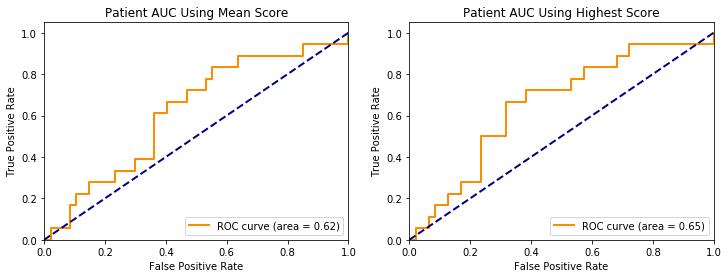

In [12]:
print("Patient accuracy (using mean score):    " + str(accuracy_score(df_test.recurrence, np.round(df_test.mean_pred))))
print("Patient accuracy (using highest value): " + str(accuracy_score(df_test.recurrence, np.round(df_test.highest_pred))))

print("\nPatient AUC (using mean score):    " + str(roc_auc_score(df_test.recurrence, list(df_test.mean_pred))))
print("Patient AUC (using highest value): " + str(roc_auc_score(df_test.recurrence, list(df_test.highest_pred))))

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_auc(df_test.recurrence, df_test.mean_pred, axs[0])
plot_auc(df_test.recurrence, df_test.highest_pred, axs[1])

axs[0].set_title("Patient AUC Using Mean Score")
axs[1].set_title("Patient AUC Using Highest Score")

# print(recall_score(list(Patient_Ys.values()), np.round(list(patient_preds_mean.values()))))
# print(precision_score(list(Patient_Ys.values()), np.round(list(patient_preds_greatest.values()))))

plt.show()

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
def evaluate(features):
    X = df_train[features]
    Y = df_train.recurrence
    clf = RandomForestClassifier(n_estimators=15, random_state=10)
    clf.fit(X, Y)
    
    importances = clf.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    sorted_importances = [importances[i] for i in sorted_indices]

    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    x = range(1, len(sorted_indices)+1)
    ax.bar(x, sorted_importances)
    ax.set_ylabel('Relative Importance')
    ax.set_xticks(range(1, len(sorted_indices)+1))
    ax.set_xticklabels([X.columns[i] for i in sorted_indices])
    plt.show()
    
    y_pred = clf.predict_proba(df_test[features])[:, 1]
    print(f'Overall Accuracy: {accuracy_score(df_test.recurrence, np.round(y_pred))}')
    print(f'Overall AUC: {roc_auc_score(df_test.recurrence, y_pred)}')
    print(f'Overall Recalll: {recall_score(df_test.recurrence, np.round(y_pred))}')
    print(f'Overall Precision: {precision_score(df_test.recurrence, np.round(y_pred))}')
    
    df_stage1 = df_test[np.logical_or(df_test['stage 1b'], df_test['stage 1a'])]
    y_pred_1 = clf.predict_proba(df_stage1[features])[:, 1] 
    print(f'Stage 1 Accuracy: {accuracy_score(df_stage1.recurrence, np.round(y_pred_1))}')
    print(f'Stage 1 AUC: {roc_auc_score(df_stage1.recurrence, y_pred_1)}')
    print(f'Stage 1 Recalll: {recall_score(df_stage1.recurrence, np.round(y_pred_1))}')
    print(f'Stage 1 Precision: {precision_score(df_stage1.recurrence, np.round(y_pred_1))}')
    
#     df_stage2 = df_test[np.logical_or(df_test['stage 2b'], df_test['stage 2a'])]
#     y_pred_2 = clf.predict_proba(df_stage2[features])[:, 1]
#     print(f'Stage 2 Accuracy: {accuracy_score(df_stage2.recurrence, np.round(y_pred_2))}')
#     print(f'Stage 2 AUC: {roc_auc_score(df_stage2.recurrence, y_pred_2)}')
#     print(f'Stage 2 Recalll: {recall_score(df_stage2.recurrence, np.round(y_pred_2))}')
#     print(f'Stage 2 Precision: {precision_score(df_stage2.recurrence, np.round(y_pred_2))}')
    

Staging + Adjuvent


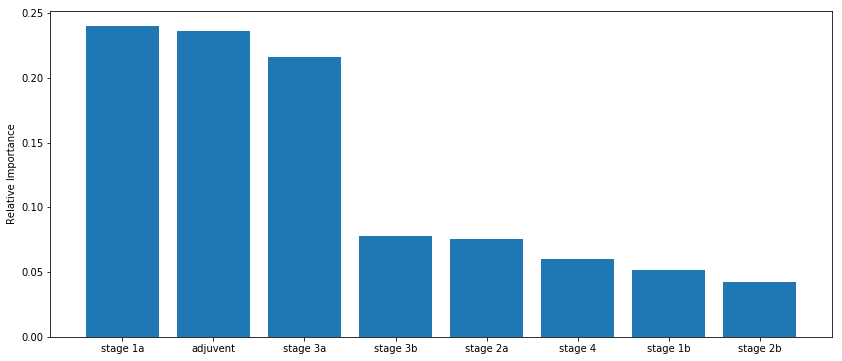

Overall Accuracy: 0.7692307692307693
Overall AUC: 0.6968085106382979
Overall Recalll: 0.2777777777777778
Overall Precision: 0.7142857142857143
Stage 1 Accuracy: 0.7818181818181819
Stage 1 AUC: 0.6424418604651163
Stage 1 Recalll: 0.0
Stage 1 Precision: 0.0


Staging + Adjuvent + Max Area


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.



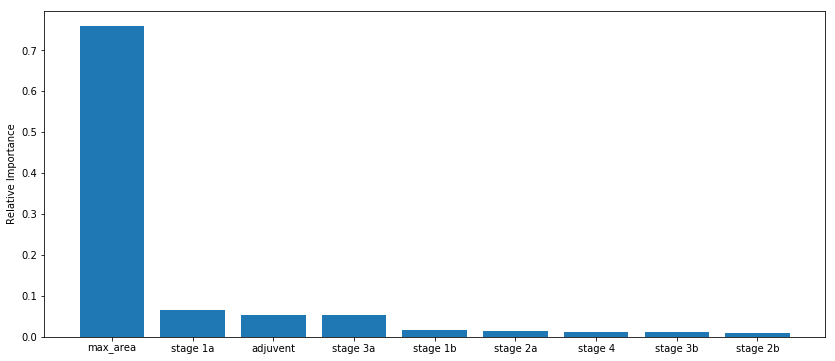

Overall Accuracy: 0.6615384615384615
Overall AUC: 0.6436170212765957
Overall Recalll: 0.4444444444444444
Overall Precision: 0.4
Stage 1 Accuracy: 0.6727272727272727
Stage 1 AUC: 0.6065891472868218
Stage 1 Recalll: 0.3333333333333333
Stage 1 Precision: 0.2857142857142857


Staging + Adjuvent + Max Area + NN


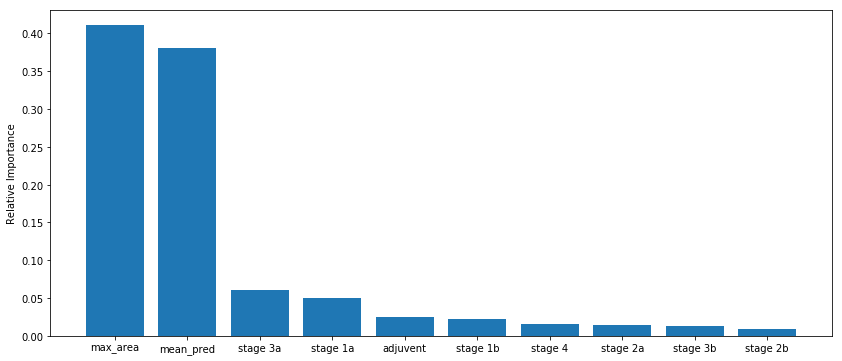

Overall Accuracy: 0.7846153846153846
Overall AUC: 0.7972813238770686
Overall Recalll: 0.3888888888888889
Overall Precision: 0.7
Stage 1 Accuracy: 0.8
Stage 1 AUC: 0.7606589147286822
Stage 1 Recalll: 0.25
Stage 1 Precision: 0.6


In [15]:
print("Staging + Adjuvent")
evaluate([
    'adjuvent', 'stage 1a', 'stage 1b',
    'stage 2a', 'stage 2b', 'stage 3a',
    'stage 3b', 'stage 4'
])
print()
print("\nStaging + Adjuvent + Max Area")
evaluate([
    'adjuvent', 'stage 1a', 'stage 1b',
    'stage 2a', 'stage 2b', 'stage 3a',
    'stage 3b', 'stage 4', 'max_area'
])
print()
print("\nStaging + Adjuvent + Max Area + NN")
evaluate([
    'adjuvent', 'stage 1a', 'stage 1b',
    'stage 2a', 'stage 2b', 'stage 3a',
    'stage 3b', 'stage 4', 'max_area',
    'mean_pred'
])